# <span style = 'color: red'>**Práctica tres.** Aprendizaje de máquina. *Clusterización*</span>

# ***Parte dos.*** **Comparación de métodos de clusterización.**

## **Simón Cuartas Rendón**

En este *notebook* de Python se aborda el desarrollo de la **segunda parte** de la *práctica tres* del curso de **Aprendizaje de Máquina**, relacionada con la clusterización vía *KMeans*, clusterización aglomerativa, DBSCAN y clusterización espectral. Para cada una de estas alternativas se va a jugar con algunos de sus parámetros de cara a ver cuál consigue optimizar el índice de silueta.

A continuación, se abren los paquetes que se usarán para dar solución al problema propuesto.

**Anotación**. Este *notebook* está disponible en línea para facilitar su revisión. Se puede acceder al repositorio de *GitHub* aquí, y en particular, a [este](https://github.com/scuartasr/aprendmaq_entregable_3) cuaderno [aquí](https://github.com/scuartasr/aprendmaq_entregable_3/blob/main/Cuadernos/02_clusterizacion.ipynb).

In [1]:
#
# Apertura de paquetes básicos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import os

# Paquetes de clusterización
from sklearn.cluster import (
    KMeans,
    AgglomerativeClustering,
    DBSCAN,
    SpectralClustering,
)
from sklearn.metrics import silhouette_score

## <span style = 'color: cyan'>***2.1***</span> Lectura de datos

Se van a leer los datos preprocesados.

In [2]:
#
# Apertura de datos
direc = '../Datos/Preprocesamiento/paises_scaled.csv.zip'               # Datos estandarizados
direc_noest = '../Datos/Preprocesamiento/paises_original.csv.zip'       # Datos sin estandarizar
paises = pd.read_csv(direc, index_col=0, compression='zip', )
paises_noest = pd.read_csv(direc_noest, index_col=0, compression='zip', )

# Dimensionalidad
print(
    f'Los datos tienen {paises.shape[0]} filas y {paises.shape[1]} columnas.'
)

Los datos tienen 167 filas y 8 columnas.


In [3]:
#
# Primeras y últimas cinco observaciones
pd.concat(
    [paises.head(), paises.tail()],
    axis=0,
    keys=['Primeras cinco observaciones', 'Últimas cinco observaciones'],
)

exports    health  \
                             country                                   
Primeras cinco observaciones Afghanistan         -1.138280  0.279088   
                             Albania             -0.479658 -0.097016   
                             Algeria             -0.099122 -0.966073   
                             Angola               0.775381 -1.448071   
                             Antigua and Barbuda  0.160668 -0.286894   
Últimas cinco observaciones  Vanuatu              0.200917 -0.571711   
                             Venezuela           -0.461363 -0.695862   
                             Vietnam              1.130305  0.008877   
                             Yemen               -0.406478 -0.597272   
                             Zambia              -0.150348 -0.338015   

                                                   imports    income  \
                             country                                   
Primeras cinco observaciones Afghanistan         -0.082455 -0.808245   
                             Albania              0.070837 -0.375369   
                             Algeria             -0.641762 -0.220844   
                             Angola              -0.165315 -0.585043   
                             Antigua and Barbuda  0.497568  0.101732   
Últimas cinco observaciones  Vanuatu              0.240700 -0.738527   
                             Venezuela           -1.213499 -0.033542   
                             Vietnam              1.380030 -0.658404   
                             Yemen               -0.517472 -0.658924   
                             Zambia              -0.662477 -0.721358   

                                                  inflation  life_expec  \
                             country                                      
Primeras cinco observaciones Afghanistan           0.157336   -1.619092   
                             Albania              -0.312347    0.647866   
                             Algeria               0.789274    0.670423   
                             Angola                1.387054   -1.179234   
                             Antigua and Barbuda  -0.601749    0.704258   
Últimas cinco observaciones  Vanuatu              -0.489784   -0.852161   
                             Venezuela             3.616865    0.546361   
                             Vietnam               0.409732    0.286958   
                             Yemen                 1.500916   -0.344633   
                             Zambia                0.590015   -2.092785   

                                                  total_fer      gdpp  
                             country                                   
Primeras cinco observaciones Afghanistan           1.902882 -0.679180  
                             Albania              -0.859973 -0.485623  
                             Algeria              -0.038404 -0.465376  
                             Angola                2.128151 -0.516268  
                             Antigua and Barbuda  -0.541946 -0.041817  
Últimas cinco observaciones  Vanuatu               0.365754 -0.546913  
                             Venezuela            -0.316678  0.029323  
                             Vietnam              -0.661206 -0.637754  
                             Yemen                 1.140944 -0.637754  
                             Zambia                1.624609 -0.629546

Nótese que el marco de datos leído conserva la dimensionalidad que se obtuvo en el *notebook* de preprocesamiento, y que el nombre de cada país corresponde a la etiqueta de cada instancia, por lo que no será involucrado en el proceso de clusterización propiamente.

**Importante.** Más adelante se graficarán mapas que permitan ver a qué clúster se asigna cada nación. Para permitir esto, es necesario corregir los índices en las bases, como se muestra enseguida:

In [4]:
# 
# Correcciones
correcciones = {
    "Bahamas": "The Bahamas",
    "Congo, Dem. Rep.": "Democratic Republic of the Congo",
    "Congo, Rep.": "Republic of the Congo",
    "Cote d'Ivoire": "Ivory Coast",
    "Gambia": "The Gambia",
    "Kyrgyz Republic": "Kyrgyzstan",
    "Lao": "Laos",
    "Macedonia, FYR": "North Macedonia",
    "Micronesia, Fed. Sts.": "Federated States of Micronesia",
    "Russia": "Russia",
    "Slovak Republic": "Slovakia",
    "South Korea": "South Korea",
    "St. Vincent and the Grenadines": "Saint Vincent and the Grenadines",
    "United States": "United States of America",
    "Vatican City": "Vatican",
}

# Aplicación

paises = paises.copy()
paises['country_corrected'] = paises.index.to_series().replace(correcciones)
paises.set_index('country_corrected', inplace=True)

paises_noest = paises_noest.copy()
paises_noest['country_corrected'] = paises_noest.index.to_series().replace(correcciones)
paises_noest.set_index('country_corrected', inplace=True)



## <span style = 'color: cyan'>***2.2***</span> *KMeans*

Se iniciará con *KMeans*. Para este, se jugará con el parámetro del número de clústeres.

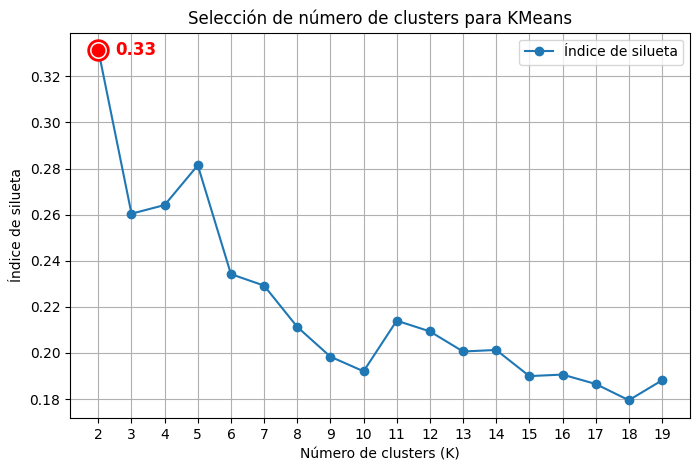

El mejor número de clusters es 2 con un índice de silueta de 0.33.


In [12]:
# Supón que tus datos ya están en X_scaled

range_n_clusters = range(2, 20)
sil_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(paises)
    sil = silhouette_score(paises, labels)
    sil_scores.append(sil)

# Identifica el punto más bajo
max_score = max(sil_scores)
max_idx = sil_scores.index(max_score)
max_k = range_n_clusters[max_idx]

# Graficar
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, sil_scores, marker='o', label="Índice de silueta")
plt.scatter(max_k, max_score, s=200, c='white', edgecolors='red', linewidths=2, zorder=5)
plt.scatter(max_k, max_score, s=80, c='red', zorder=6)

# Mostrar solo enteros en el eje x
plt.xticks(range_n_clusters)

# Etiqueta a la izquierda del punto óptimo
plt.text(max_k + 1.75, max_score, f"{max_score:.2f}", ha='right', va='center', 
         fontsize=12, fontweight='bold', color='red')

plt.xlabel("Número de clusters (K)")
plt.ylabel("Índice de silueta")
plt.title("Selección de número de clusters para KMeans")
plt.grid(True)
plt.legend()
plt.show()


# Mejor número de clusters
print(f'El mejor número de clusters es {max_k} con un índice de silueta de {max_score:.2f}.')


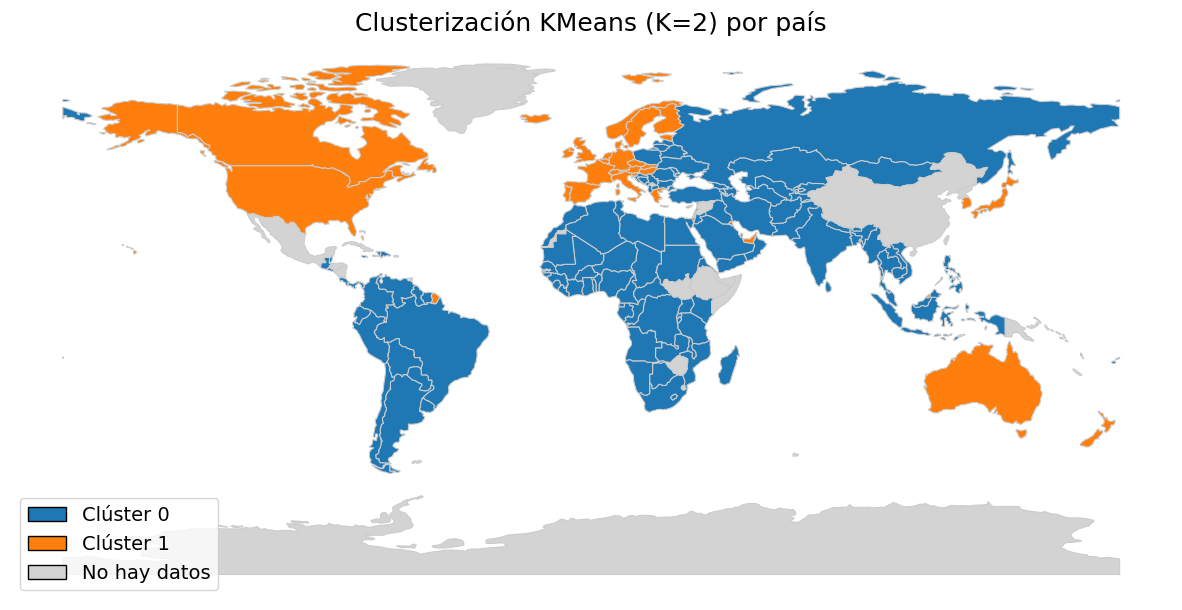

In [ ]:


# 1. Ajusta KMeans (ya deberías tener max_k y paises corregido)
kmeans = KMeans(n_clusters=max_k, random_state=42)
labels = kmeans.fit_predict(paises)

result = paises.copy()
result['cluster'] = labels

# 2. Carga el shapefile mundial desde el archivo descargado previamente
shapefile_path = '../Datos/Mapas/ne_110m_admin_0_countries.shp'
world = gpd.read_file(shapefile_path)

# 3. Haz el merge por nombre de país
merged = world.merge(result, left_on='NAME_EN', right_index=True, how='left')

# 4. Define colores contrastantes
colores = ['#1f77b4', '#ff7f0e']  # azul, naranja
cmap = mcolors.ListedColormap(colores)

# 5. Graficar el mapa
fig, ax = plt.subplots(figsize=(15, 10))
merged.plot(
    column='cluster',
    cmap=cmap,
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=False,  # La leyenda la agregaremos manualmente
    missing_kwds={
        "color": "lightgrey",
        "label": "No hay datos"
    }
)
ax.set_title(f'Clusterización KMeans (K={max_k}) por país', fontsize=18)
ax.axis('off')

# 6. Leyenda manual
legend_elements = [
    Patch(facecolor=colores[0], edgecolor='k', label='Clúster 0'),
    Patch(facecolor=colores[1], edgecolor='k', label='Clúster 1'),
    Patch(facecolor='lightgrey', edgecolor='k', label='No hay datos'),
]
ax.legend(handles=legend_elements, loc='lower left', fontsize=14)

plt.show()


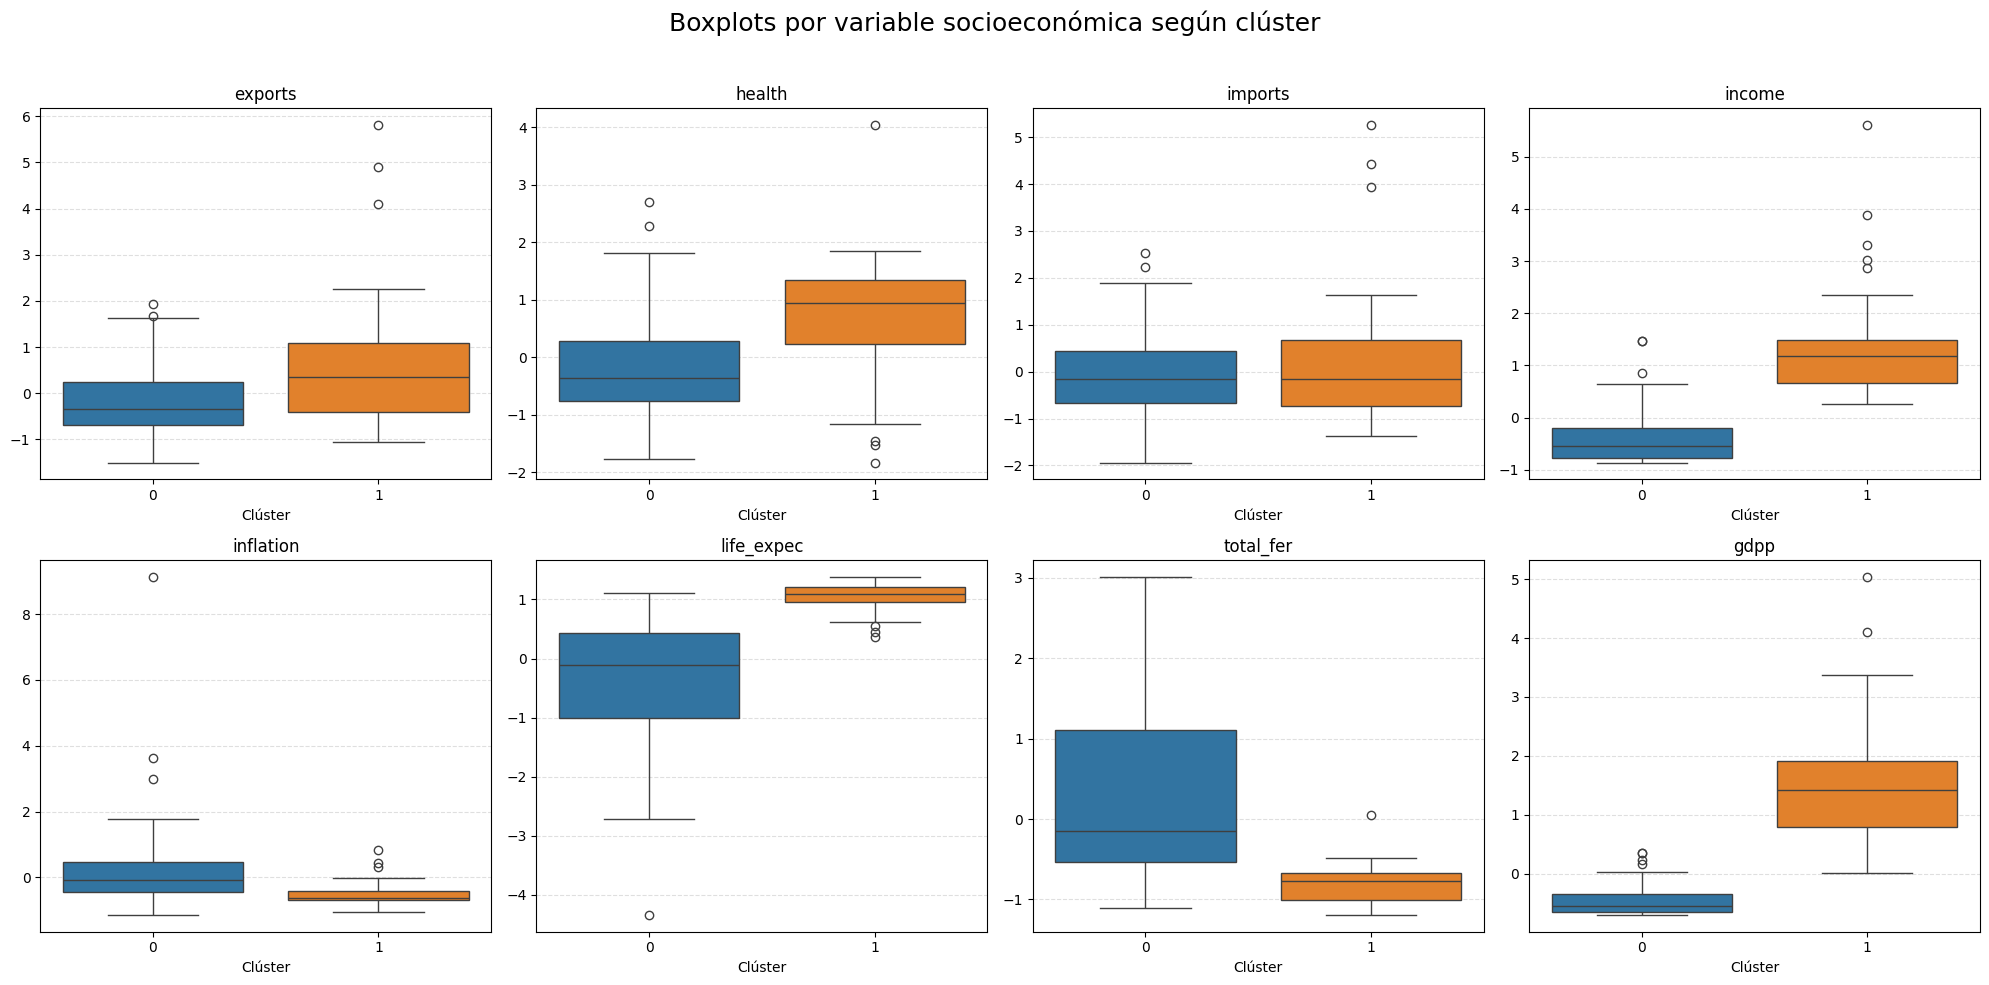

In [7]:
result_reset = result.reset_index().rename(columns={'index': 'country'})
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i, var in enumerate(paises.columns.tolist()):
    ax = axs[i // 4, i % 4]
    sns.boxplot(
        data=result_reset,
        x='cluster',
        y=var,
        hue='cluster',
        palette=['#1f77b4', '#ff7f0e'],
        legend=False,
        ax=ax
    )
    ax.set_title(var)
    ax.set_xlabel('Clúster')
    ax.set_ylabel('')
    ax.grid(True, axis='y', linestyle='--', alpha=0.4)
fig.suptitle('Boxplots por variable socioeconómica según clúster', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

